# Anitápolis TFA multiple Inversions

This notebook performs the inversion using Levenberg-Marquadt's algorithm of total field anomaly (TFA).

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import pandas as pd

from fatiando.vis import mpl

In [31]:
from datetime import date
today = date.today()
# dd/mm/YY
d4 = today.strftime("%b-%d-%Y")

### Auxiliary functions

In [32]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing model parameters

In [33]:
# output of inversion
inversion = dict()

In [34]:
data = pd.read_csv('anitapolis_decimated_tfa_residual_cut.txt', skipinitialspace=True, delim_whitespace=True)

In [35]:
data['GPSALT'] = - data['GPSALT'] + 800

In [36]:
mask = (data['GPSALT'].get_values()<0.)
data = data[mask]

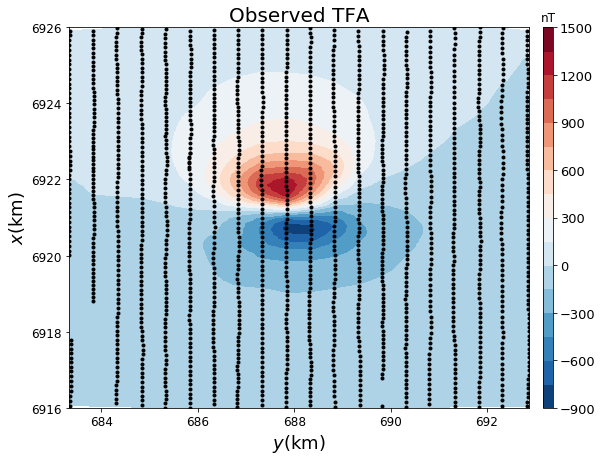

In [37]:
plt.figure(figsize=(10,7))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(data['Y'], data['X'], data['mag_res1'], 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.plot(data['Y'], data['X'], 'k.')
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
#estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.show()

In [38]:
xp = data['X'].get_values()
yp = data['Y'].get_values()
zp = data['GPSALT'].get_values()
alt = data['ALTURA'].get_values()
dobs = data['mag_res1'].get_values()

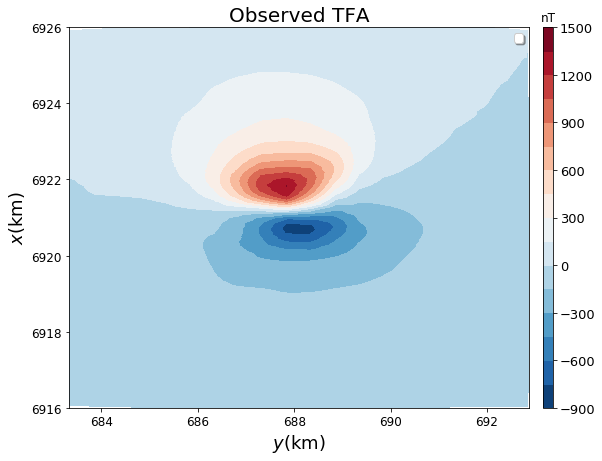

In [39]:
plt.figure(figsize=(10,7))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
plt.show()

In [40]:
np.min(zp)

-688.01

### Parameters of the initial model

In [41]:
M = 20 # number of vertices per prism
L = 6 # number of prisms
P = L*(M+2) + 1 # number of parameters

#figura
incs = -21
decs = -11
int_min = 11.
int_max = 20.
intensity = np.linspace(int_min, int_max, 10)

# depth to the top, thickness and radius
z0_min = 0.
z0_max = 180.
z0 = np.linspace(z0_min, z0_max, 10)
dz = 630.
r = 700.

x0 = 6921000.
y0 = 688000.

# main field
inc, dec = [-37.05, -18.17]

In [42]:
z0

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.])

In [43]:
intensity

array([11., 12., 13., 14., 15., 16., 17., 18., 19., 20.])

### Limits

In [44]:
# limits for parameters in meters
rmin = 10.
rmax = 1200.
y0min = 687000.
y0max = 699000.
x0min = 6916000.
x0max = 6923000.
dzmin = 10.
dzmax = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

### Variation

In [45]:
# variation for derivatives
deltax = 0.01*np.max(100.)
deltay = 0.01*np.max(100.)
deltar = 0.01*np.max(100.)
deltaz = 0.01*np.max(100.)

### Outcropping parameters

In [46]:
# outcropping body parameters
m_out = np.zeros(M + 2)
#m_out = model['param_vec'][:M+2]

### Folder to save the results

In [47]:
mypath = 'tfa_inversion/upward_multiple_int_min%d_int_max%d_z0_min%d_z0_max%d_r%d_dz%d_V%d_L%d' % (int_min, int_max, z0_min, z0_max, r, dz, M, L)
mypath += d4
if not os.path.isdir(mypath):
   os.makedirs(mypath)

In [48]:
mypath

'tfa_inversion/upward_multiple_int_min11_int_max20_z0_min0_z0_max180_r700_dz630_V20_L6Apr-30-2020'

### Regularization parameters

In [49]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 10.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 1.0e-4  # adjacent radial distances within each prism
a2 = 1.0e-3   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 1.0e-4 # vertically adjacent origins
a6 = 1.0e-8   # zero order Tikhonov on adjacent radial distances
a7 = 1.0e-5     # zero order Tikhonov on thickness of each prism

In [50]:
delta = np.array([deltax, deltay, deltar, deltaz])
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

In [51]:
itmax = 30
itmax_marq = 10
tol = 1.0e-4     # stop criterion

### Inversion

In [52]:
inversion_results = []
for j, z in enumerate(z0):
    for k, i in enumerate(intensity):
        alpha = np.array([a1, a2, a3, a4, a5, a6, a7])
        print 'inversion: %d  top: %d  intensity: %2.f' % (j*z0.size + k, z, i)
        model0, m0 = mfun.initial_cylinder(M, L, x0, y0, z, dz, r, inc, dec, incs, decs, i)
        d_fit, m_est, model_est, phi_list, model_list, res_list = mfun.levmarq_tf(
            xp, yp, zp, m0, M, L, delta,
            itmax, itmax_marq, lamb,
            dlamb, tol, mmin, mmax,
            m_out, dobs, inc, dec,
            model0[0].props, alpha, z, dz
        )
        inversion_results.append([m_est, phi_list, model_list, dobs - d_fit])

inversion: 0  top: 0  intensity: 11
it:  0   it_marq:  0   lambda: 1e+01   init obj.: 7.42318e+03  fin obj.: 3.85844e+03
it:  1   it_marq:  0   lambda: 1e+00   init obj.: 3.85844e+03  fin obj.: 2.35700e+03
it:  2   it_marq:  0   lambda: 1e-01   init obj.: 2.35700e+03  fin obj.: 3.39969e+03
it:  2   it_marq:  1   lambda: 1e+00   init obj.: 2.35700e+03  fin obj.: 1.81387e+03
it:  3   it_marq:  0   lambda: 1e-01   init obj.: 1.81387e+03  fin obj.: 2.59129e+03
it:  3   it_marq:  1   lambda: 1e+00   init obj.: 1.81387e+03  fin obj.: 1.47847e+03
it:  4   it_marq:  0   lambda: 1e-01   init obj.: 1.47847e+03  fin obj.: 2.95972e+03
it:  4   it_marq:  1   lambda: 1e+00   init obj.: 1.47847e+03  fin obj.: 1.17712e+03
it:  5   it_marq:  0   lambda: 1e-01   init obj.: 1.17712e+03  fin obj.: 2.75893e+03
it:  5   it_marq:  1   lambda: 1e+00   init obj.: 1.17712e+03  fin obj.: 1.18112e+03
it:  5   it_marq:  2   lambda: 1e+01   init obj.: 1.17712e+03  fin obj.: 1.04300e+03
it:  6   it_marq:  0   lambda

# Results

In [53]:
inversion['x'] = xp
inversion['y'] = yp
inversion['z'] = zp
inversion['observed_data'] = dobs

In [54]:
inversion['x'].size

1597

In [55]:
inversion['inc_dec'] = [incs, decs]
inversion['z0'] = z0
inversion['initial_dz'] = dz
inversion['intial_r'] = r
inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
inversion['regularization'] = np.array([a1, a2, a3, a4, a5, a6, a7])
inversion['tol'] = tol
inversion['main_field'] = [inc, dec]
inversion['intensity'] = intensity

In [56]:
inversion['results'] = inversion_results

In [57]:
file_name = mypath+'/inversion.pickle'
with open(file_name, 'w') as f:
    pickle.dump(inversion, f)

In [58]:
mypath

'tfa_inversion/upward_multiple_int_min11_int_max20_z0_min0_z0_max180_r700_dz630_V20_L6Apr-30-2020'

###### 